<a href="https://colab.research.google.com/github/Rathika04/CSC206/blob/main/CSC206_Final_Project_Rathika.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC-206: Text Analytics
# Rathika Nair

## FINAL PROJECT: Mine the Concordy

### Part 1: Overview

I'm giving you access to a repository of text files from [The Concordiensis Dataset](https://cs-gitlab.union.edu/webbn/concordy/). This is a collection of text files, generated from the PDF of the Concordy from 1880 to 2000.

This is 'messy' data. The text files are extracted from the PDF using OCR - optical character recognition - which means that there are errors. It is not an accurate process, and a lot of words are misspelled, or have additional characters inserted in them (or that are missing). But overall, it's enough to support an exploration - remember, our techniques are based around approximation in any case.

Worse, each text file represents the complete text of an issue of the Concordiensis. There is no segmentation of pages, sections or articles. You can TRY to find articles, based on keywords for instance.

In the repository, there are two directories. There's the raw text - which you know how to deal with - in the directory called Text. There's also a directory called PDF in which, if you're interested, you can find the source PDF scans of the copies of the newspaper, from 1896 onward.

UPDATE: I've moved the raw text files to the CS server, but I've left them on gitlab also, so you can look at them if you need to.

Your job is both simple, and NOT clearly defined. I want you to work with this data, and tell me a story. What can you find? What results do you get? What do they mean? What interesting features of the language can you find that are interesting.

Some ideas include:
- An exploration of key people who have played a role in the college
- A study of a sports team or organization - when it started, who was involved, key players
- A look at the use of specific words over time
- The language shift over a century

You do not have to choose one of these. Feel free to explore something that interests you. I expect

You don't have to look at ALL the text. For instance, you could examine just a particular decade - say the 1960s - or compare the 1880s directly to the 1980s.

You should clearly state what you're looking at. And you may not find anything. The noise could be too much, but that's ok. I'm not so much interested in your *results*, as I am in your attempts, and in your interpretation of your results.


### Report Submission

1. Introduction

This study focuses on the usage of the words "investment" and "economics" in The Concordiensis, Union College's student newspaper, spanning from 1910 to 2000. The aim is to analyze the frequency of these terms over time and explore the contexts in which they appear. Specifically, I seek to identify trends in the usage of these words, such as how often they occur in relation to key historical events (e.g., the Great Depression, World War II, and the founding of the Student Investment Fund in 1986). Additionally, I want to examine the most common words associated with investment and economics by analyzing their surrounding contexts, which can provide insight into the academic and social environments at Union College throughout the years.

### Introduction to the Concordy

Below I show you how I work with the Concordy text, as an example. In the TEXT directory, there are text files for each issue of the Concordiensis. Each file comprises a month. So for example, the file:

> 1880-01.txt

is the text file that contains the issue for January, 1880.

If you click on the file name, you get to see the contents. The URL for that is:

https://cs-gitlab.union.edu/webbn/concordy/blob/master/Text/1880-01.txt

HOWEVER - this is NOT the URL you would use to read the text from Python. Instead I'm pointing you at the text stored on the CS web server. The link for that is:

https://cs.union.edu/~webbn/Concordy/concordy-master-Text/Text/1880-01.txt

Make sure you are accessing the right text.

Below, I'm going to show you the code that iterates through ALL of the text data, and graphs the use of the terms *men* and *women*. I'm doing the counting on a yearly basis, so I need to collect ALL of the text for a single year, and then count over that, then repeat for the next year.

This is going to run over all the text from all the issues for 120 years. It might take a while. Think about this when you're doing your work. It makes sense to start with small bits of text to make sure your ideas work, before launching on a massive text attack!


In [ ]:
# First I'm going to do something a little bad
# I'm going to circumvent a little bit of a security issue

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# I'm importing the usual URL libraries, but
# with a bit extra
# What happens if I try to open a page that doesn't exist?
# For instance, 1880-07.text
# There IS no issue in July, 1880. If I try to access it, I'll get
# an error. So below, I show you a kind of exception handling - what
# to do WHEN I get an error.

import pickle
from google.colab import drive
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import string
import urllib
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop = stopwords.words('english')

In [ ]:

# https://cs.union.edu/~webbn/Concordy/concordy-master-Text/Text/1896-01.txt

# Here's the folder where all the raw texts live:

folder = "https://cs.union.edu/~webbn/Concordy/concordy-master-Text/Text/"


# And I'm going to generate the years, as integers

start_year = 1910
end_year = 2000
years = range(start_year,end_year+1)


# I'm setting up lists, where I'll store the counts of the words
# men and women, in order

investment = []
economics = []
investmentFund = []
investmentClub = []
totalSents = []

# Now iterate through each (integer) year

for year in years:

  # Print the year, so I can see what processing is happening
  #print(year)

  # Set up a variable to hold ALL of the text FOR THAT YEAR
  year_text =""

  # There are typically 12 months in a year
  for month in range(1,13):

    monthStr = str(month)

    if month < 10:
      monthStr = "0"+monthStr


    # So I want the year and month as strings, so I can concatenate them
    # into a file path for me to open

    # Typically, we've written:
    # response = urllib.request.urlopen('path to file')
    # data = response.read()

    # Here I've just broken it down a bit more
    # I'm constructing the path
    # Then forming a request

    path = folder+str(year)+"-"+monthStr+".txt"
    req = Request(path)

    # I'm going to TRY to open the file
    # IF it works, I execute the stuff in the else statement
    # Which means I read the file as normal

    # IF it doesn't, I probably get some sort of error
    # (in this case a 404 file not found error)
    # In which case I should report it, and move on
    # You can see the error if you try to go here:
    # https://cs-gitlab.union.edu/webbn/concordy/raw/master/Text/1880-07.txt


    # SIDE NOTE: Which issues are missing and why? Some of them
    # are probably obvious - maybe others are not?

    try:
      urlopen(req)
    except HTTPError as e:
      # do something
      pass
    except URLError as e:
      # do something
      pass
    else:
      response = urllib.request.urlopen(path)
      data = response.read()
      text = data.decode('utf-8')
      year_text+=text

  # Once I've iterated through all the months
  # I have the text for the year
  # So now, work on it.
  # Notice I count ' men'. Why? Why the space?

  year_text = year_text.lower()
  investmentCount = year_text.count("investment")
  econCount = year_text.count("economics")
  fundCount = year_text.count("investment fund")
  clubCount = year_text.count("investment club")
  sentences = nltk.sent_tokenize(year_text)

  totalSents.append(sentences)
  investment.append(investmentCount)
  economics.append(econCount)
  investmentFund.append(fundCount)
  investmentClub.append(clubCount)

In [ ]:
start_year = 1910
end_year = 2000
years = range(start_year,end_year+1)

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/Data/'

Mounted at /content/drive


In [ ]:
'''
pickleOut = open(path + "sentences.pickle", 'wb')
pickle.dump(totalSents, pickleOut)
pickleOut.close()
'''

In [ ]:
inFile = open(path + "sentences.pickle", 'rb')
totalSents = pickle.load(inFile)
inFile.close()

In [ ]:
'''
pickleOut = open(path + "investmentCount.pickle", 'wb')
pickle.dump(investment, pickleOut)
pickleOut.close()
'''

In [ ]:
inFile = open(path + "investmentCount.pickle", 'rb')
investment = pickle.load(inFile)
inFile.close()

In [ ]:
'''
pickleOut = open(path + "econCount.pickle", 'wb')
pickle.dump(economics, pickleOut)
pickleOut.close()
'''

In [ ]:
inFile = open(path + "econCount.pickle", 'rb')
economics = pickle.load(inFile)
inFile.close()

In [ ]:
'''
pickleOut = open(path + "fundCount.pickle", 'wb')
pickle.dump(investmentFund, pickleOut)
pickleOut.close()
'''

In [ ]:
inFile = open(path +  "fundCount.pickle", 'rb')
investmentFund = pickle.load(inFile)
inFile.close()

In [ ]:
'''
pickleOut = open(path + "clubCount.pickle", 'wb')
pickle.dump(investmentClub, pickleOut)
pickleOut.close()
'''

In [ ]:
inFile = open(path +  "clubCount.pickle", 'rb')
investmentClub = pickle.load(inFile)
inFile.close()

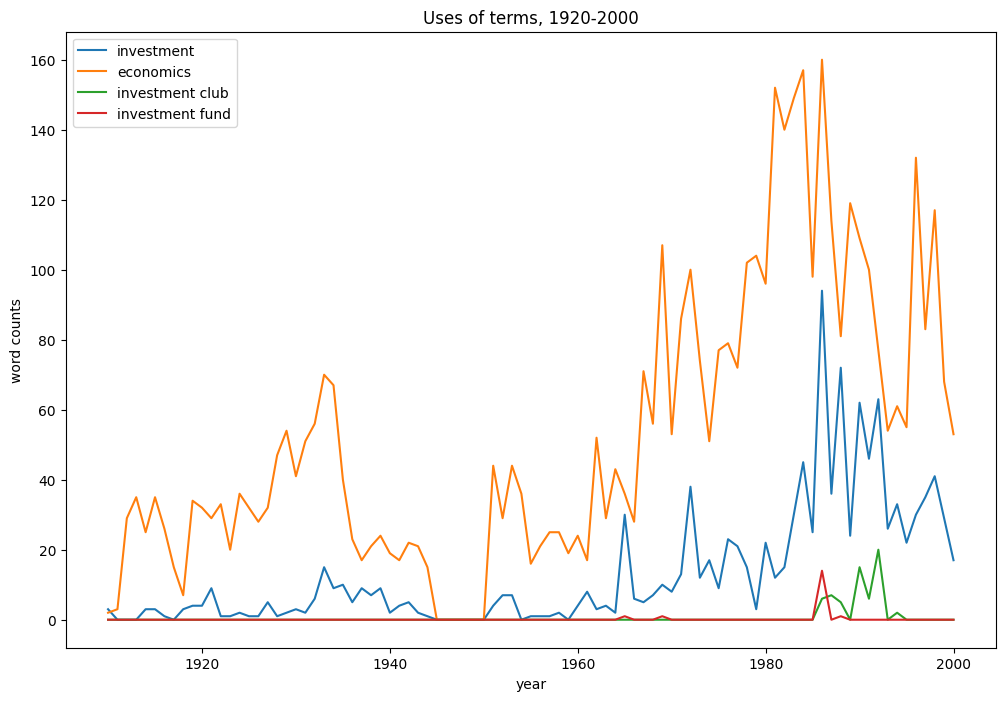

In [ ]:
# Ok, let's do the plotting
# Years on the x axis
# Count of terms on the y axis
# Lines for men and women

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12, 8))

#plt.plot(range(1929, 1941), label='Great Depression')
plt.plot(years,investment,label='investment')
plt.plot(years,economics,label='economics')
plt.plot(years,investmentClub,label='investment club')
plt.plot(years,investmentFund,label='investment fund')

plt.title('Uses of terms, 1920-2000')
plt.xlabel('year')
plt.ylabel('word counts')
plt.legend()
plt.show()

2. **Data processing**

To begin, I analyzed the frequency of "investment" and "economics" between 1910 and 2000. I also focused on niche terms like "investment fund" and "investment club", since the Union College Student Investment Fund (SIF) was founded in 1986.

I converted all text data to lowercase to standardize the words (e.g., "Investment" and "investment" should be counted as the same word). I then tokenized the text into sentences to facilitate further analysis. I then created a graph to show how often each word ocurrs. his allowed me to visualize trends and fluctuations in the usage of these terms over time.

3. **Results: Analysis of graph**

Looking at the graph, the word "economics" appears more frequently than "investment" throughout the Concordiensis. "Investment" is mentioned more often than niche terms like "investment fund" and "investment club", which makes sense given these terms refer to specific topics within the broader category of investment.

Both "investment" and "economics" see an increase in usage from the 1920s to the mid-1930s. This coincides with the Great Depression (1929-1939) and a general global interest in economics and investments during this period. There is a noticeable dip in usage around 1940, likely due to World War II (1939-1945), when the focus of the nation shifted away from academic discussions to wartime concerns. From the 1980s onwards, there is a significant spike in mentions of "investment fund" and "investment club". This period corresponds with the founding of the Student Investment Fund (1986). This could also be related to major financial events like Black Monday (1987) and the Dotcom Bubble (1995-2000).

4. **Conclusions**

The frequency of terms related to economics and investment reflects broader historical events such as the Great Depression, World War II, and the rise of the Student Investment Fund in the late 20th century.

In [ ]:
#get surrounding words from chosen word
def getBigrams(chosenWord, aList):
  for year in totalSents:
    for sent in year:
      words = nltk.word_tokenize(sent)
      words = [word for word in words if word not in string.punctuation and word not in stop]

      if chosenWord in words:
        n1 = words[0]

        for n2 in words[1:]:
          bigram = n1 +' '+ n2
          aList.append(bigram)
          n1 = n2
  return aList

In [ ]:
investBigrams = []
investBigrams = getBigrams("investment", investBigrams)

In [ ]:
'''
pickleOut = open(path + "investBigrams.pickle", 'wb')
pickle.dump(investBigrams, pickleOut)
pickleOut.close()
'''

In [ ]:
inFile = open(path + "investBigrams.pickle", 'rb')
investBigrams = pickle.load(inFile)
inFile.close()

In [ ]:
print("There are {} bigrams".format(len(investBigrams)))
c1 = Counter(investBigrams)
print('The top 10 most common bigrams when "investment" is used in a sentence')
c1.most_common(10)

There are 14922 bigrams
The top 10 most common bigrams when "investment" is used in a sentence


[('investment club', 61),
 ('union college', 44),
 ('-- --', 34),
 ('investment banking', 31),
 ('new york', 27),
 ('investment challenge', 27),
 ('healthy investment', 25),
 ('collegiate investment', 25),
 ('college investment', 23),
 ('investment accounts', 23)]

2. **Data processing**

I processed the text by iterating through all the sentences for each year, tokenizing them into individual words, and removing punctuation and stop words. Tokenization allowed me to standardize the text and make word search more efficient. Next, I focused on sentences that included the word "investment" and created bigrams from these sentences to analyze adjacent word pairs.

Finally, I examined the 10 most frequent bigrams that occurred alongside "investment" to identify the most common words that typically appear next to it.

3. **Results**

I conducted a bigram analysis for sentences containing the word "investment", which revealed the most common adjacent words.

"Investment club" is the most frequent bigram appearing 61 times. Union college appears 2nd most appearing 44 times. Investment banking appears 3rd most appearing 31 times. These results suggest that "investment club" was a prominent topic, especially after the formation of the Student Investment Fund, while "investment banking" reflects the academic and career-oriented discussions around financial fields.

I am ignoring "-- --" as the 3rd most appearing as that was punctuation that did not get removed.

4. **Conclusion**

Given that Union College has a Student Investment Fund (SIF), it is natural that any mention of the word "investment" would often be in relation to the investment club. The frequent appearance of "investment banking" alongside "investment" further reflects the academic and career focus on finance, which was likely a growing area of interest during the late 20th century.

This analysis highlights how "investment" in the context of Union College is closely tied to its investment club and the broader academic discussions around financial careers.

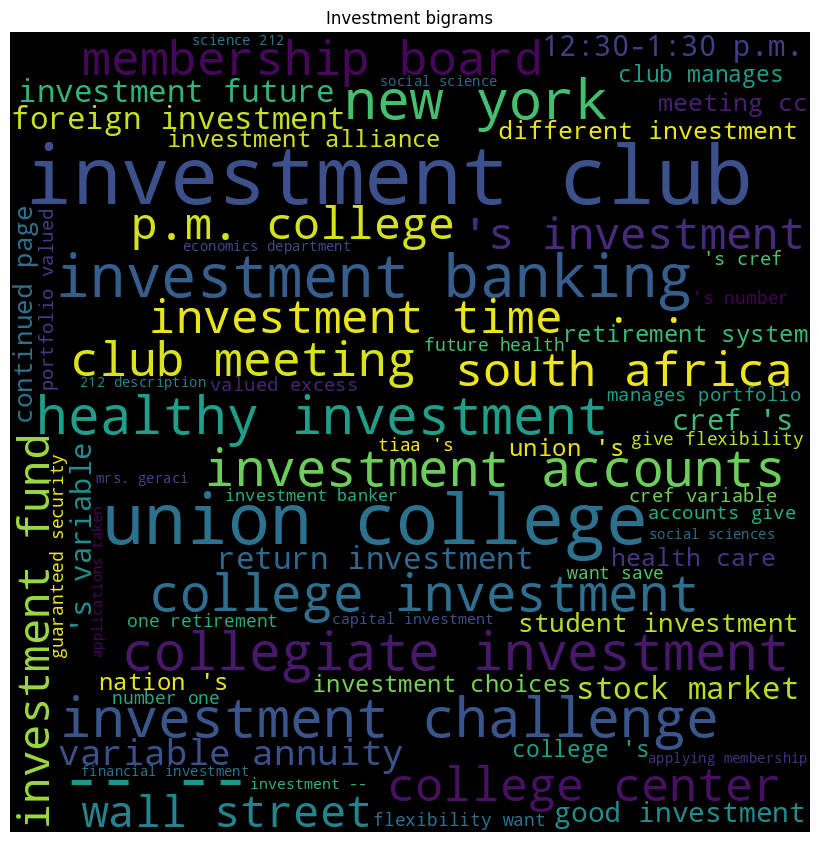

In [ ]:
#Show a wordcloud of the bigrams
wc = WordCloud(width=800, height=800, min_font_size=14).generate_from_frequencies(c1)
plt.figure(figsize=(10,8))
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Investment bigrams")

plt.imshow(wc)
plt.show()

I also generated a world cloud of the bigrams. The word cloud helps visualize the most frequent bigrams. With "Investment club" standing out along with "union college" and "investment banking". The surprising appearance of "stock market" in the word cloud, despite not being in the top 10 bigrams, suggests it was still a significant part of the discourse around investment. This insight further demonstrates the broader interest in financial markets at the time, even if it was not always paired directly with "investment".

In [ ]:
#get surrounding words from chosen word

investBigrams2 = []

for year in totalSents[65:]:
  for sent in year:
    words = nltk.word_tokenize(sent)
    words = [word for word in words if word not in string.punctuation and word not in stop]

    if "investment" in words:
      n1 = words[0]

      for n2 in words[1:]:
        bigram = n1 +' '+ n2
        investBigrams2.append(bigram)
        n1 = n2


In [ ]:
print('There are {} bigrams "investment" is used in a sentence after 1985'.format(len(investBigrams2)))
c3 = Counter(investBigrams2)
c3.most_common(10)

There are 11094 bigrams "investment" is used in a sentence after 1985


[('investment club', 61),
 ('union college', 43),
 ('investment banking', 31),
 ('-- --', 29),
 ('investment challenge', 27),
 ('collegiate investment', 25),
 ('investment accounts', 23),
 ('healthy investment', 23),
 ('college investment', 22),
 ('club meeting', 20)]

2. **Data processing**

To refine the analysis, I focused on bigrams appearing after 1985, the period surrounding the creation of the Student Investment Fund (SIF). I aimed to explore how the context of the word "investment" evolved during this time when investment-related activities at Union College became more structured and formalized.

After preprocessing the text—removing punctuation, stopwords, and tokenizing the data into words and sentences—I isolated sentences containing "investment". I then generated bigrams (pairs of adjacent words) from these sentences and calculated their frequency to identify the most commonly associated terms.

3. **Results**

"Investment club" appeared the most with it appearing  61 times followed by
 "union college", 43 times, "investment banking", 31 times, and so on.

4. **Conclusion**
"Investment club" remains the most frequent bigram in both cases, demonstrating its central role in campus discussions around investments. "Union College" and "investment banking" also appear prominently in both cases. While "New York" appeared in the overall dataset, it is absent in the post-1985 subset. This likely shows a shift from talking about locations to focusing on specific campus initiatives. "Club meeting" surfaces post-1985, suggesting increased activity within the investment club, possibly influenced by the SIF's creation.

The comparison highlights the significance of the investment club at Union College. Post-1985, discussions become more centered around campus-specific initiatives and professional opportunities in finance.

In [ ]:
econBigrams = []
econBigrams = getBigrams("economics", econBigrams)

In [ ]:
'''
pickleOut = open(path + "econBigrams.pickle", 'wb')
pickle.dump(econBigrams, pickleOut)
pickleOut.close()
'''

In [ ]:
inFile = open(path + "econBigrams.pickle", 'rb')
econBigrams = pickle.load(inFile)
inFile.close()

In [ ]:
print("There are {} bigrams".format(len(econBigrams)))
print('The top 10 most common bigrams when "economics" is used in a sentence')
c2 = Counter(econBigrams)
c2.most_common(10)

There are 117396 bigrams
The top 10 most common bigrams when "economics" is used in a sentence


[('-- --', 725),
 ('political science', 261),
 ('economics department', 213),
 ('elementary economics', 184),
 ('history economics', 144),
 ('modern languages', 139),
 ('introduction economics', 138),
 ('economics major', 136),
 ('professor economics', 135),
 ('a. m.', 127)]

2. **Data processing**

Just as I processed sentences containing "investment", I looped through all the sentences each year and tokenized them into individual words to analyze the context of "economics". During preprocessing, I removed punctuation and stop words to focus on meaningful content.

To understand the contextual use of "economics", I generated bigrams (pairs of adjacent words) from sentences containing this word and identified the 10 most common ones. This helped reveal the most frequent associations of "economics" in The Concordiensis.  

3. **Results**

"Political science" was the most common bigram with 261 occurrences, which was unexpected. This indicates a strong connection between economics and political science, likely reflecting interdisciplinary discussions on these topics. "Economics department" appeared 213 times, reflecting the department's significant role in the academic landscape at Union College. "Elementary economics" appeared 184 times but I am not sure what it is referring to. "Economics major" and "professor economics" also frequently appeared, highlighting the emphasis on economics as a field of study and its academic presence at the college.

4. **Conclusions**

The analysis shows that economics was often discussed in the context of other academic disciplines, particularly political science. This suggests that economics was considered integral to broader intellectual and interdisciplinary discussions at Union College.

The frequent pairing of "economics" with terms like "economics department" and "economics major" further reflects its prominence as a key area of study within the college's academic environment.

The use of phrases like "elementary economics" and "introduction economics" suggests an emphasis on foundational economic education.

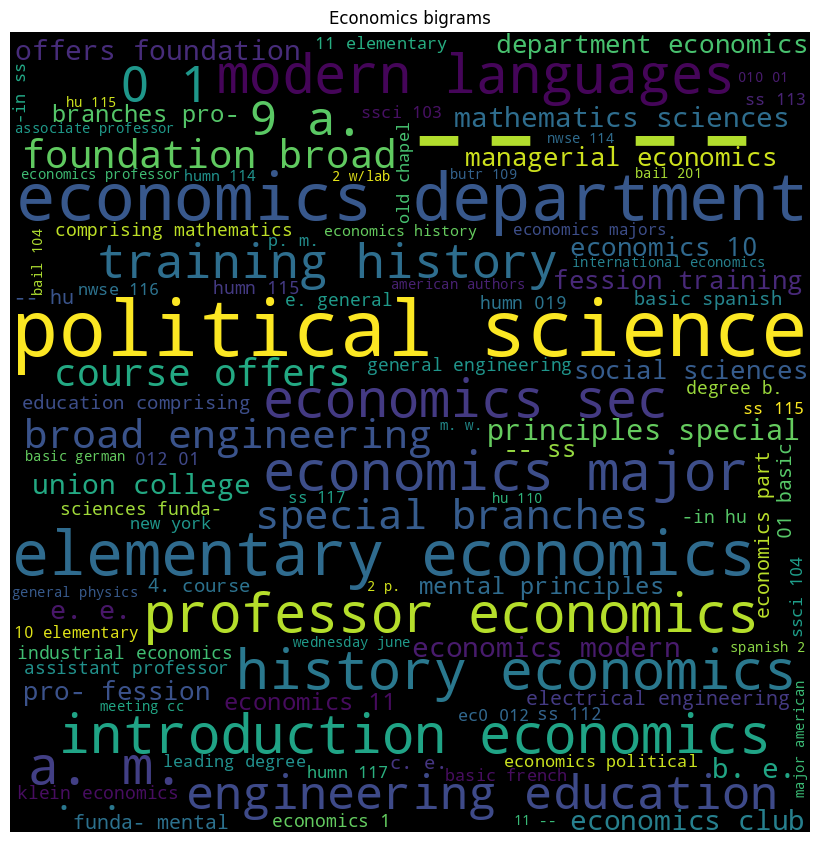

In [ ]:
#Show a wordcloud of the bigrams
wc = WordCloud(width=800, height=800, min_font_size=14).generate_from_frequencies(c2)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Economics bigrams")

plt.imshow(wc)
plt.show()

The word cloud I generated helps visualize the most frequent bigrams as well. "Political science" and "elementary economics" stand out. "Offers foundation" seems to support broadening accessibility of economics to students. "Managerial economics" is a major offered at the school.

**Overall Conclusion**

The analysis of the terms "investment" and "economics" in The Concordiensis from 1910 to 2000 reveals significant trends in their usage, reflecting both global historical events and local academic developments at Union College. The frequency of these terms aligns with major events such as the Great Depression, World War II, and the founding of the Student Investment Fund in 1986. Additionally, the contextual analysis of bigrams highlights the growing importance of investment-related discussions, particularly with the rise of the investment club, and the interdisciplinary nature of economics. This study offers valuable insights into the evolving academic and social focus at Union College over the 20th century.